In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
filename = '/content/drive/MyDrive/DSDojo/Colab Notebooks/Coding Dojo/Project 2/Project 2 cleaned final.csv'
df = pd.read_csv(filename, index_col='ID')
df.rename(columns={'Other':'Other_Rel_ID','Other.1':'Other'},inplace= True)
df.head()

,Still_Open,Art_Film_Music_1,Broadcasting_TV_2,Camps_Retrest_Confrc_3,Child_Adopt_Orphan_4,Chuch_Plant_5,Consult_Org&Tech_Support_6,Counceling_Rehab_7,Relig_Reform_Revival_8,Econom_Develop_9,Fellowship_Prof_Assoc_10,Health_Med_Serc_11,Housing_Cloth_Food_12,Interfaith_Dialog_13,Leader_Train_Edu_14,Legal_Political_Advocacy_15,Missions_16,Preach_Speak_Lect_17,Publishing_18,Other_19,Q3_ONE,Any_Category_Selec,Christian_NP,Jewish_NP,Muslim_NP,Hindu_NP,Buddhist_NP,IR_NP,Not_Reli_NP,Other_NP,Missing_Reli_Id_NP,Identifies_w_Denomination,Denom_Bible_Believ,Denom_Charismatic,Denom_Ecumenical,Denom_Evangelical,Denom_Fundamental,Denom_Mainline,Denom_Pentecostal,Denom_Theo_Conserv,...,Evangelical,Fundamentalist,Mainline,Pentecostal,Seeker,Theologically_Conservative,Theologically_Liberal,Other_Rel_ID,Att_Relig_Serc,Wtinessed_Healing,Felt_Called,Had_Vision,Heard_Voice_God,Had_Dream,Had_Relig_Conv_Exper,Changed_Profoundly_Due_Relig_Exper,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Main_Category,Refused_Budget_Perc,Num_Budget_Spons,Perc_Finc_Indiv_Gifts_Don,Perc_Sales_Goods,Perc_Memberships,Perc_Spec_Fundraise,Perc_Grants_Don_Relig_Cong,Perc_Grants_Don_Denom_Off,Perc_Grants_Don_Relig_Found,Perc_Grant_Don_Sec_Found,Perc_Grant_Don_Bus_Corp,Perc_Grant_Gov,Perc_Other,Other
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11028,1.0,0,0,1,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,10.0,6,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,...,1,0,0,0,0,1,0,0,8,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,10,0,4,5.0,1.0,0,30,0,0,2,0,0,0.0,0,0
11051,1.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,16.0,4,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,...,1,1,0,0,0,1,0,0,8,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,16,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0
11055,1.0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,1,1,0,1,7.0,8,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,9,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,7,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0
11056,1.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,8.0,5,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,8,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0
11068,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,...,1,1,0,0,0,1,0,0,9,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,19,0,3,30.0,0.0,0,70,60,0,0,0,0,0.0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 919 entries, 11028 to 33188
Columns: 313 entries, Still_Open to Other
dtypes: float64(11), int64(300), object(2)
memory usage: 2.2+ MB


In [ ]:
df.dtypes


Still_Open                  float64
Art_Film_Music_1              int64
Broadcasting_TV_2             int64
Camps_Retrest_Confrc_3        int64
Child_Adopt_Orphan_4          int64
                             ...   
Perc_Grant_Don_Sec_Found      int64
Perc_Grant_Don_Bus_Corp       int64
Perc_Grant_Gov              float64
Perc_Other                    int64
Other                         int64
Length: 313, dtype: object

We have some values in the target column that are blank. We are going to remove these and make them a 'fake' testing set. Then we will drop these from the original dataset

In [ ]:
dfTestLater = df[df['Still_Open'].isnull()]


In [ ]:
df = df[df['Still_Open'].notna()]


# Cleaning the Data - Breakdown

The data in this dataset (survey) was extremely messy and I chose to clean it in SSMS instead of python (The cleaning script can be found in the GitHub Repo). In this dataset, there were missing values in almost every column, ranging from a small amount to around 60% or more of a feature. Dropping these features was not an option as the data not only had an imbalanced target value, but was itself very small (<1000 rows). 
We therefore had to pick between imputing a value based on some metric calculated from that feature, creating a missing value field as an option for categorical features, and/or infering the missing value based on logic. For example, for number of years of religious training, there were 2 records with only the letter 'B' in them. Since these were hand-written surveys, it could be infered with some certainty that the survery taker had written '8', but the software used to read the answers in saw it as a 'B'

Another example of the previously stated scenario, was unfortunately one that occured all too often, and we had to make some logical assumptions that were perhaps not as certain as changing a B into an 8. This was when we had multiple yes/no feature columns where more than half of the data was missing. It was infered that these answers were left blank because the survey-taker had decided the question was not applicable to them (which means they should have answered no). Therefore for many of these columns we replaced Null values with 0. An example of this type of question would be "For each of the following financial sources, please indicate whether any of your organization's budget came from that source in 2010 by shading YES or NO. .... - Other (please specify) - Any portion of budget?"

Below is a list - not necessarily exhaustive) of features that where yes/no, and where the Nulls were replaced with zeros:



*   Do you or one of the other leaders of this nonprofit serve on the governing or advisory boards for any other faith-based nonprofit(s)?
*   Does this nonprofit have a website?
*   Does this nonprofit have a Facebook account?
*   Does this nonprofit have a Twitter account?
*   Has the primary founder been ordained?
*   Not counting this nonprofit, how many other nonprofit organizations has the primary founder helped start?

*   All questions regarding the previous occupation of the primary founder such as: Prior to starting this nonprofit organization, what other occupation(s) did the primary founder have? - Clergy or minister in a church, synagogue, mosque, temple, or other religious congregation (Q38A_1--Q38V_1)
*   Excluding items like travel reimbursements, do you receive a salary or wage for your work in this organization?
*   All questions concerning 'experiences'. Eg: "Please indicate whether or not you have ever had any of the following experiences - I witnessed or experienced a miraculous healing." (Q52A--Q52G)


The following questions were numerical features and missing values were thus imputed with the stated metric:


*   At the time of this nonprofit organization's creation, how old was the primary founder? : Replaced with Average
*   Number of Hours per Month at NP (Num_Hrs_PM_At_NP): Average
*   Number of Founders at Start (Num_Founders): Mode (To avoid the average being pulled down by multiple 0s, or by extreme outliers of like 200 founders. Same principal applied below
*   Number of Founders Still Involved (Num_Founders_Still_Inv): Mode

Q37 ("Not counting this nonprofit, have any of the primary founder's family members started nonprofit organizations?") was dropped completely out of the model as I could not make sense of the responses. The responses ranged from 0-2 which made no sense as this was a yes/no question. This was data I randonly acquired from the internet and so I had no way of questioning anyone on what certain questions or responses meant.

The next few features were more complicated. The transformations were all done in SQL, but here is a breakdown of what was performed and the reasons behind it:

Q3_ONE asked the respondents to classify which of the previous ~19 Qs best described the MAIN category of the nonprofit. The previous 19 columns all had varying categories to which respondents had to answer Yes/No - and they could say yes/no to as many categories as they felt were applicable to their Nonprofit. Since the answer to Q3_ONE was a number representing each of the previous 19 columns, we already had a categorical column encoded for us, however when dealing with null values I took two different approaches:
1.   For Nulls value records where there WERE items selected in the previous 18 columns, I assigned a value of '20' which would represent "Multiple Categories as Main Category"
2.   For Items that had absolutely NO values (all 'No'/0) in the previous 19 columns, I assigned a value of '19' which would represent 'Other' as the main category. 19 was already an existing column, and therefore even if they had left the other column blank or assigned a 0, I essentially overwrote that with a 1, as if you aren't any of the designated categories, you must obviously be in the 'other' category

For Q8 "Do any of the activities of this nonprofit occur outside of your own state but within the United States?" I replaced all missing values with a 0, because I noticed that almost all those with a missing value in Q8 also had a missing value in Q9 "Do any of the activities of this nonprofit occur outside of the United States?". If a NPs activities occur neither outside the USA, nor in the USA but outside their state, then the only other place they could occur is within their own state, which means they should have answered 0 to Q8. Additionally, for Q9, if they had left Q8 and Q9 blank then Q9 was 0, but if in Q9_YES("If yes, please specify in which nations these activities occur.") had information filled out but they left Q9 blank, I replaced the Null with a 1. Also if they answered 'Canada', I changed any blanks or erroneous 0s with a 1. Because Canada is not inside of the USA............

SQL CODE:

```
case when ([Q9] = '' and Q8 = 0 and Q9_YES <> '') OR upper(Q9_Yes) = 'CANADA' then 1 else 0 end as [Outside_USA]
```










Q9_YES posed some interesting problems. It contained information about which countries each NP served. This was written in by hand and was extremely messy. One option (the more obvious one maybe) was to drop the column entirely. However, I was convinced that the specific countries a NP served in could be a huge factor in their survival, so I didnt want to just leave it out.

I first considered using a python library (pycountry) to try extract the information, but unfortunately the data was too messy for that to be the solution. We had typos, continents mixed with countries, regions instead of countries (like 'middle east') etc. I could have manually written some transformations in SQL, but again this would have taken very long. So, due to the code that would take too long to write AND the fact that this was a one time model (no new data would ever arise), I decided to import the otherwise cleaned data into Excel and manually type out the information from said column. I also decided to rather go with continent/region instead of country, since that would have been too many categorical features and I would have been close to having more columns than rows. There were only arounf 300 rows with data for this feature, so the endevour was not too time consuming.

The most complicated missing values I had to deal with concerned the budget questions. Budget/finances were too important of a question to just leave out of a model concerning the survivability of NPs. The problem was that this was one of the most heavily saturated areas with Null values. The questions took the following format: The first one was a yes/no question asking if they received any % of their budget from a certain type of sponsor/source, the follow up question asked, if yes, to specifiy what % was gotten from that source. Most NPs would fill in the yes/no section, but refused to fill out the %. I created a new flag column to keep track of the NPs that refused to specify where they got their funding from.
However, there were many who did fill out one or both columns (for each sponsor type) - though they did not always do so very well. For example, the %s did not add up to 100, or people wrote the % as a fraction, so 10% was .1. Some would say they didnt receive money from a certain source but would then specify a % value in the following column, or they would indicate they received they had gotten funding from 5 sources, but only provided percentages for 3 of them.

I did not want to just leave out these columns, and so this is how I chose to handle these missing values:
* If a % was given, but the indicator was blank, the indicator was filled with a '1', else if the % was 0/blank and the indicator blank, then the % was set to 0 and the indicator set to 0
*  If only 1 indicator column was checked, but the total budget % was less than 100% then the Other column indicator was set to '1' and the balance of the % (100-whatever was given) was placed in the Other % column.
*   If both the indicator columns were filled out, as well as the % columns, but the values did not equal 100%, then a new metric was calculated where 100% was divided by the number of indicator columns set (total number of sponsors indicated) and then divided equally between the values. If the Other column already had a value in it then then % was reset accordingly





# Cleaning the Data - The Python Part

Check for duplicates

In [ ]:
df.duplicated().value_counts()

False    901
dtype: int64

Drop Unnecessary columns:

In [ ]:
dfNP =  df.drop(columns=['Q3_ONE','Any_Category_Selec','Q9_YES','Tot_Budget_Perc','Perc_Other_1','Other_1','Perc_Grants_Don_Relig_Cong1','Perc_Finc_Indiv_Gifts_Don1','Perc_Sales_Goods1','Perc_Memberships1','Perc_Spec_Fundraise1',
                         'Perc_Grants_Don_Denom_Off1','Perc_Grants_Don_Relig_Found1','Perc_Grant_Don_Sec_Found1','Perc_Grant_Don_Bus_Corp1','Perc_Grant_Gov1'])

In [ ]:
dfNP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 11028 to 33188
Columns: 297 entries, Still_Open to Other
dtypes: float64(7), int64(289), object(1)
memory usage: 2.0+ MB


For Q24_1 (How many founders would you say this nonprofit had?) and Q24_2 (How many of these founders are still involved with this nonprofit?) we are going to replace the null values with the mode. This should not greatly effect the results as most NPs had between 1-3 founders so it makes sense to replace with the most common value instead of a 0 or an average.

In [ ]:
dfNP['Num_Founders'].value_counts(dropna=False)

2.0      240
1.0      220
3.0      120
4.0       75
5.0       60
6.0       42
10.0      33
8.0       22
NaN       19
7.0       19
15.0      10
12.0       9
20.0       8
9.0        6
11.0       4
16.0       3
0.0        2
25.0       2
200.0      1
21.0       1
50.0       1
41.0       1
30.0       1
19.0       1
13.0       1
Name: Num_Founders, dtype: int64

In [ ]:
numfound = dfNP['Num_Founders'].mode()[0]
numfoundinv = dfNP['Num_Founders_Still_Inv'].mode()[0]
dfNP['Num_Founders'] = dfNP['Num_Founders'].replace(np.nan,numfound)

In [ ]:
numfound

2.0

In [ ]:
numfoundinv

1.0

In [ ]:
dfNP['Num_Founders_Still_Inv'] = dfNP['Num_Founders_Still_Inv'].replace(np.nan,numfoundinv)

In [ ]:
dfNP['Num_Founders_Still_Inv'].value_counts(dropna=False)

1.0      293
2.0      263
3.0      105
0.0       52
4.0       52
5.0       45
6.0       31
7.0       15
8.0       15
10.0      11
12.0       6
9.0        4
25.0       2
15.0       2
20.0       1
200.0      1
36.0       1
16.0       1
120.0      1
Name: Num_Founders_Still_Inv, dtype: int64

Check for inconistent datatypes

In [ ]:
dfNP.select_dtypes(exclude='int')

,Still_Open,Num_Founders,Num_Founders_Still_Inv,Yrs_Of_Training,Num_Hrs_PM_At_NP,Perc_Finc_Indiv_Gifts_Don,Perc_Sales_Goods,Perc_Grant_Gov
ID,,,,,,,,
11028,1.0,1.0,1.0,12,200.0,5.0,1.0,0.0
11051,1.0,15.0,3.0,4,20.0,100.0,0.0,0.0
11055,1.0,1.0,1.0,2,30.0,100.0,0.0,0.0
11056,1.0,4.0,2.0,0,4.0,100.0,0.0,0.0
11068,1.0,4.0,0.0,0,100.0,30.0,0.0,0.0
...,...,...,...,...,...,...,...,...
33172,1.0,7.0,0.0,0,12.0,40.0,15.0,0.0
33176,1.0,3.0,1.0,0,50.0,75.0,10.0,0.0
33179,1.0,3.0,1.0,0,160.0,50.0,10.0,0.0


Lets convert these to ints or floats where applicable


In [ ]:
dfNP['Still_Open'] = dfNP['Still_Open'].astype(int)
dfNP['Num_Founders'] = dfNP['Num_Founders'].astype(int)
dfNP['Num_Founders_Still_Inv'] = dfNP['Num_Founders_Still_Inv'].astype(int)


In [ ]:
dfNP['Yrs_Of_Training'].sort_values()

ID
32741    "1 year in youth ministry, 3 years in Music Ed...
12760                         "4 Undergrad, 4 at Seminary"
32328                         "8, 2 to 3 classes per year"
31552                   "Just started, less than one year"
31022                         "THM 4 years, D Min 4 years"
                               ...                        
13722                                             On going
32900                                        Over 40 years
21199                                    Part time student
32801    Was in the middle of my first year which is st...
32812                                                 many
Name: Yrs_Of_Training, Length: 901, dtype: object

In [ ]:
#manually convert items that will cause an issue with the code that will follow in the second cell. Also give all ambiguous records like "many" a value of 99 which will later be replaced with 
# the Average

In [ ]:
dfNP['Yrs_Of_Training'] = dfNP['Yrs_Of_Training'].replace(['3 1/2','3.5','4 yrs','4 years',
                                                           '"1 year in youth ministry, 3 years in Music Education"'],
                                                          '4').replace(['"4 Undergrad, 4 at Seminary"','"THM 4 years, D Min 4 years"','"8, 2 to 3 classes per year"','B'],
                                                                       '8').replace(['Was in the middle of my first year which is still continuing','I','Part time student',
                                                                                     '"Just started, less than one year"'],'1').replace('9 years 10 months','10').replace(
                                                                                         '"They would say a lifetime, but technically 8 beyond undergrad"','12'
                                                                                     ).replace(['many','Lifetime','On going'],'99')

Remove all text and leave only numbers

In [ ]:
dfNP['Yrs_Of_Training'] = dfNP['Yrs_Of_Training'].str.extract('(\d+)',expand = False)

Now we replace 99 with the average of the values where the values are not 99 or 0

In [ ]:
avgtraining = round(dfNP[(dfNP['Yrs_Of_Training']!='99') & (dfNP['Yrs_Of_Training']!='0')]['Yrs_Of_Training'].astype(int).mean())
dfNP['Yrs_Of_Training'] = dfNP['Yrs_Of_Training'].astype(int).replace(99,avgtraining)
dfNP['Yrs_Of_Training'].value_counts(dropna=False)

0     474
4      89
3      73
2      71
1      33
6      32
5      27
8      26
10     15
12     10
7      10
30      6
9       5
15      5
14      3
20      3
25      3
50      2
11      2
35      2
40      2
16      1
18      1
22      1
23      1
27      1
31      1
41      1
54      1
Name: Yrs_Of_Training, dtype: int64

In [ ]:
dfNP.select_dtypes(exclude=['int','float'])
#All values are in the correct datatype format now

""
ID
11028
11051
11055
11056
11068
...
33172
33176
33179


Encode the only non-encoded column

In [ ]:

dfNP = pd.get_dummies(dfNP, columns=['Main_Category'], drop_first= True)
dfNP

,Still_Open,Art_Film_Music_1,Broadcasting_TV_2,Camps_Retrest_Confrc_3,Child_Adopt_Orphan_4,Chuch_Plant_5,Consult_Org&Tech_Support_6,Counceling_Rehab_7,Relig_Reform_Revival_8,Econom_Develop_9,Fellowship_Prof_Assoc_10,Health_Med_Serc_11,Housing_Cloth_Food_12,Interfaith_Dialog_13,Leader_Train_Edu_14,Legal_Political_Advocacy_15,Missions_16,Preach_Speak_Lect_17,Publishing_18,Other_19,Christian_NP,Jewish_NP,Muslim_NP,Hindu_NP,Buddhist_NP,IR_NP,Not_Reli_NP,Other_NP,Missing_Reli_Id_NP,Identifies_w_Denomination,Denom_Bible_Believ,Denom_Charismatic,Denom_Ecumenical,Denom_Evangelical,Denom_Fundamental,Denom_Mainline,Denom_Pentecostal,Denom_Theo_Conserv,Theo_liberal,Denom_Inter_Denom,...,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Refused_Budget_Perc,Num_Budget_Spons,Perc_Finc_Indiv_Gifts_Don,Perc_Sales_Goods,Perc_Memberships,Perc_Spec_Fundraise,Perc_Grants_Don_Relig_Cong,Perc_Grants_Don_Denom_Off,Perc_Grants_Don_Relig_Found,Perc_Grant_Don_Sec_Found,Perc_Grant_Don_Bus_Corp,Perc_Grant_Gov,Perc_Other,Other,Main_Category_2,Main_Category_3,Main_Category_4,Main_Category_5,Main_Category_6,Main_Category_7,Main_Category_8,Main_Category_9,Main_Category_10,Main_Category_11,Main_Category_12,Main_Category_13,Main_Category_14,Main_Category_15,Main_Category_16,Main_Category_17,Main_Category_18,Main_Category_19,Main_Category_20
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11028,1,0,0,1,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,4,5.0,1.0,0,30,0,0,2,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11051,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
11055,1,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
11056,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
11068,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,3,30.0,0.0,0,70,60,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33172,1,0,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,4,40.0,15.0,0,40,0,0,0,0,5,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
33176,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,3,75.0,10.0,15,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
33179,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,4,50.0,10.0,30,0,10,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
#Lastly double check there are no Nulls left
dfNP.isnull().sum().sum()


52

In [ ]:
null_columns=dfNP.columns[dfNP.isnull().any()]

In [ ]:
null_columns

Index(['Num_Hrs_PM_At_NP'], dtype='object')

In [ ]:
#replace nulls in 'Num_Hrs_PM_At_NP' with the average
avghrsmonth = round(dfNP['Num_Hrs_PM_At_NP'].mean())
dfNP['Num_Hrs_PM_At_NP'].fillna(avghrsmonth,inplace = True)

In [ ]:
null_columns=dfNP.columns[dfNP.isnull().any()]
null_columns

Index([], dtype='object')

# EDA - Visualizations

These will be done exclusively in Power BI and will not be included here. Please see .Pbix file in Github Repo, as well as some images of the visuals included in the .README

# Modeling

**Baseline Model**

In [ ]:
BaseAcc = dfNP['Still_Open'].sum()/dfNP['Still_Open'].count()
BaseAcc
#Must beat 0.959 Accuracy to have a worthwhile model - rough. haha

0.9589345172031076


**Train Test Split, Followed by over-sampling to counter an unbalanced target vector**

In [ ]:
y = dfNP['Still_Open'].values
X = dfNP.drop(columns='Still_Open')


In [ ]:
X.shape

(901, 314)

In [ ]:
#TTS
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 3,stratify = y)

In [ ]:
#OverSample
oversample = SMOTE()
Xo, yo = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Xo.shape

(1294, 314)

In [ ]:
yo.shape

(1294,)

In [ ]:
#scale
scaler = StandardScaler()
scaler.fit(Xo)
Xo = scaler.transform(Xo)
X_test = scaler.transform(X_test)

**Pick PCA Components**

In [ ]:
pca = PCA()
pca.fit(Xo)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Proportion of Explained Variance')

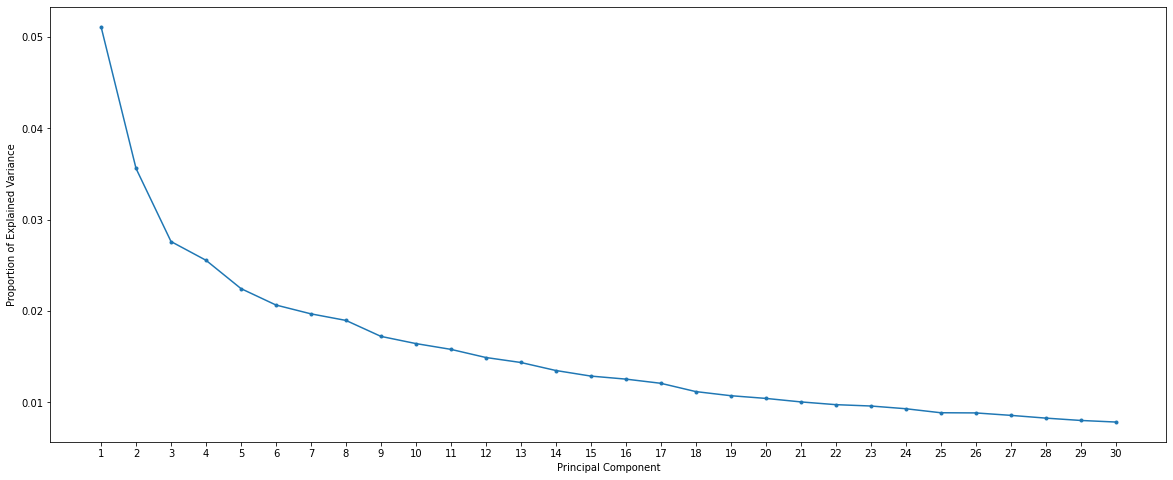

In [ ]:
#plot first 30 vars only
plt.figure(figsize=(20,8))
plt.plot(range(1, 31), pca.explained_variance_ratio_[:30], marker = '.')
plt.xticks(ticks = range(1, 31))
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')

In [ ]:
# how many PCs do we need to explain at lease 95% of the variance
totvar = 0
numPC = 0
i= 0
while totvar <.95:
  totvar += pca.explained_variance_ratio_[i]
  i += 1
  numPC += 1
numPC

189

In [ ]:
Xo.shape

(1294, 314)

In [ ]:
pca = PCA(.95)
Xopca = pca.fit_transform(Xo)
XopcaTest = pca.transform(X_test)

In [ ]:
Xopca.shape

(1294, 189)

In [ ]:
yo.shape

(1294,)

Therefore, we need 190 PCs to explain at least 95% of the variance

**KNN Classification - With PCA and Pipeline**

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
n = [25,50,100,200]
params = {'n_neighbors':[10,25,50,100]}
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=10, random_state= 3)
scoregrid = {'Acc':'accuracy'}
search = GridSearchCV(estimator=knn,param_grid=params,n_jobs=-1, cv=cv)
search.fit(Xopca,yo)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=3),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [10, 25, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
search.best_params_

{'n_neighbors': 10}

In [ ]:
search.best_score_

0.6157633713447667

In [ ]:
#Final KNN Model:
print('KNN (n=10) Training Accuracy:', accuracy_score(yo, search.predict(Xopca)))
print('KNN (n=10) Testing Accuracy:', accuracy_score(y_test, search.predict(XopcaTest)))

KNN (n=10) Training Accuracy: 0.6738794435857806
KNN (n=10) Testing Accuracy: 0.336283185840708


**Random Forest - Wih PCA and Pipeline**

In [ ]:
rf = RandomForestClassifier(random_state = 3)

In [ ]:
n = [25,50,100,200]
#c = [0.001,0.01,0.1,1]
params = {'n_estimators': n, 'max_depth':[None, 3,  5, 10]}
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=10, random_state= 3)
scoregrid = {'Acc':'accuracy'}

In [ ]:
rfsearch = GridSearchCV(estimator=rf,param_grid=params,n_jobs=-1, cv=cv)
rfsearch.fit(Xopca,yo)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=3),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                     

In [ ]:
rfsearch.best_params_

{'max_depth': None, 'n_estimators': 25}

In [ ]:
rfsearch.best_score_

1.0

In [ ]:
print('RF (n_estimators: 50, Max_depth: None) Training Accuracy:', accuracy_score(yo, rfsearch.predict(Xopca)))
print('RF (n_estimators: 50, Max_depth: None) Testing Accuracy:', accuracy_score(y_test, rfsearch.predict(XopcaTest)))

RF (n_estimators: 50, Max_depth: None) Training Accuracy: 1.0
RF (n_estimators: 50, Max_depth: None) Testing Accuracy: 0.9601769911504425


**Logistic Regression - With PCA and Pipeline**

In [ ]:
 lr = LogisticRegression(random_state = 3)

In [ ]:
#n = [25,50,100,200]
c = [0.001,0.01,0.1,1]
params = {'C':c,'penalty':['l1','l2']}
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=10, random_state= 3)
scoregrid = {'Acc':'accuracy'}
lrsearch = GridSearchCV(estimator=lr,param_grid=params,n_jobs=-1, cv=cv)
lrsearch.fit(Xopca,yo)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=3),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=3, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
lrsearch.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [ ]:
lrsearch.best_score_

0.9809897937804916

In [ ]:
print('lr (C: 1,  penalty: l2) Training Accuracy:', accuracy_score(yo, lrsearch.predict(Xopca)))
print('lr (C: 1, penalty: l2) Testing Accuracy:', accuracy_score(y_test, lrsearch.predict(XopcaTest)))

lr (C: 1,  penalty: l2) Training Accuracy: 0.999227202472952
lr (C: 1, penalty: l2) Testing Accuracy: 0.9247787610619469


XGBoost

In [ ]:
xgb = XGBClassifier(random_state = 3)

In [ ]:
n = [25,50,100,200]
params = {'n_estimators': n, 'max_depth':[3, 4, 6,8], 'learning_rate':[0.1,0.3,0.5], 'subsample':[1,0.5]}
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=10, random_state= 3)
scoregrid = {'Acc':'accuracy'}
xgbsearch = GridSearchCV(estimator=xgb,param_grid=params,n_jobs=-1, cv=cv)
xgbsearch.fit(Xopca,yo)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=3),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=3, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'max_depth': [3, 4

In [ ]:
xgbsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}

In [ ]:
xgbsearch.best_score_

1.0

In [ ]:
print('xgb (learning_rate: 0.1, max_depth: 3, n_estimators: 50, subsample: 1) Training Accuracy:', accuracy_score(yo, xgbsearch.predict(Xopca)))
print('xgb (learning_rate: 0.1, max_depth: 3, n_estimators: 50, subsample: 1) Testing Accuracy:', accuracy_score(y_test, xgbsearch.predict(XopcaTest)))

xgb (learning_rate: 0.1, max_depth: 3, n_estimators: 50, subsample: 1) Training Accuracy: 1.0
xgb (learning_rate: 0.1, max_depth: 3, n_estimators: 50, subsample: 1) Testing Accuracy: 0.9601769911504425


# Final Model: Random Forest

Though both XGBoost and Random Forest returned the same results we are going to use Random Forest In our Final Model so that we can get feature importances if necessary.

Our production algorithm is a Random Forest Model with default hyperparameters and n_estimators: 25

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 3,stratify = y)

pipefinal = make_pipeline(StandardScaler(),PCA(.95),RandomForestClassifier(n_estimators=25, random_state = 3)) 
pipefinal.fit(X_train,y_train)

print('Training accuracy:', pipefinal.score(X_train, y_train))
print('Test accuracy:', pipefinal.score(X_test, y_test))

Training accuracy: 0.9985185185185185
Test accuracy: 0.9601769911504425


# Predicting Missing Target Values - This section is incomplete and will be addressed at a later stage

In our original data we had rows where the target value was missing. Let's use our model to predict what we think those values should have been. (We will never know if this is right though)


In [ ]:
dfTestLater.shape

(18, 313)

In [ ]:
#X_test_nan_target = dfTestLater.drop(columns='Still_Open')

In [ ]:
#clean

X_test_nan_target =  dfTestLater.drop(columns=['Q3_ONE','Any_Category_Selec','Q9_YES','Tot_Budget_Perc','Perc_Other_1','Other_1','Perc_Grants_Don_Relig_Cong1','Perc_Finc_Indiv_Gifts_Don1','Perc_Sales_Goods1','Perc_Memberships1','Perc_Spec_Fundraise1',
                         'Perc_Grants_Don_Denom_Off1','Perc_Grants_Don_Relig_Found1','Perc_Grant_Don_Sec_Found1','Perc_Grant_Don_Bus_Corp1','Perc_Grant_Gov1'])

In [ ]:
X_test_nan_target.shape

(18, 297)

In [ ]:
numfound = X_test_nan_target['Num_Founders'].mode()[0]
numfoundinv = X_test_nan_target['Num_Founders_Still_Inv'].mode()[0]
X_test_nan_target['Num_Founders'] = X_test_nan_target['Num_Founders'].replace(np.nan,numfound)

In [ ]:
X_test_nan_target['Num_Founders_Still_Inv'] = X_test_nan_target['Num_Founders_Still_Inv'].replace(np.nan,numfoundinv)

In [ ]:
X_test_nan_target.select_dtypes(exclude=['int','float'])

,Yrs_Of_Training
ID,
11148,8
11269,2
11741,3
11825,0
12548,4
12571,0
12725,0
12944,0
13758,0


In [ ]:
X_test_nan_target['Num_Founders'] = X_test_nan_target['Num_Founders'].astype(int)
#X_test_nan_target['Still_Open'] = X_test_nan_target['Still_Open'].astype(int)
X_test_nan_target['Num_Founders_Still_Inv'] = X_test_nan_target['Num_Founders_Still_Inv'].astype(int)
X_test_nan_target['Yrs_Of_Training'] = X_test_nan_target['Yrs_Of_Training'].astype(int)

In [ ]:
X_test_nan_target = X_test_nan_target.drop(columns='Still_Open')

In [ ]:
X_test_nan_target = pd.get_dummies(X_test_nan_target, columns=['Main_Category'], drop_first= True)

In [ ]:
X_test_nan_target.isnull().sum().sum()

2

In [ ]:
#replace nulls in 'Num_Hrs_PM_At_NP' with the average
avghrsmonth = round(X_test_nan_target['Num_Hrs_PM_At_NP'].mean())
X_test_nan_target['Num_Hrs_PM_At_NP'].fillna(avghrsmonth,inplace = True)

In [ ]:
X_test_nan_target.shape

(18, 301)

In [ ]:
print(pipefinal.predict(X_test_nan_target))

In [ ]:
dfTestLater

,Still_Open,Art_Film_Music_1,Broadcasting_TV_2,Camps_Retrest_Confrc_3,Child_Adopt_Orphan_4,Chuch_Plant_5,Consult_Org&Tech_Support_6,Counceling_Rehab_7,Relig_Reform_Revival_8,Econom_Develop_9,Fellowship_Prof_Assoc_10,Health_Med_Serc_11,Housing_Cloth_Food_12,Interfaith_Dialog_13,Leader_Train_Edu_14,Legal_Political_Advocacy_15,Missions_16,Preach_Speak_Lect_17,Publishing_18,Other_19,Q3_ONE,Any_Category_Selec,Christian_NP,Jewish_NP,Muslim_NP,Hindu_NP,Buddhist_NP,IR_NP,Not_Reli_NP,Other_NP,Missing_Reli_Id_NP,Identifies_w_Denomination,Denom_Bible_Believ,Denom_Charismatic,Denom_Ecumenical,Denom_Evangelical,Denom_Fundamental,Denom_Mainline,Denom_Pentecostal,Denom_Theo_Conserv,...,Evangelical,Fundamentalist,Mainline,Pentecostal,Seeker,Theologically_Conservative,Theologically_Liberal,Other_Rel_ID,Att_Relig_Serc,Wtinessed_Healing,Felt_Called,Had_Vision,Heard_Voice_God,Had_Dream,Had_Relig_Conv_Exper,Changed_Profoundly_Due_Relig_Exper,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Main_Category,Refused_Budget_Perc,Num_Budget_Spons,Perc_Finc_Indiv_Gifts_Don,Perc_Sales_Goods,Perc_Memberships,Perc_Spec_Fundraise,Perc_Grants_Don_Relig_Cong,Perc_Grants_Don_Denom_Off,Perc_Grants_Don_Relig_Found,Perc_Grant_Don_Sec_Found,Perc_Grant_Don_Bus_Corp,Perc_Grant_Gov,Perc_Other,Other
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11148,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,19,0,6,40.0,0.0,0,0,2,0,0,1,2,4.0,51,1
11269,NaN,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,3,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,9,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,4,0,4,60.0,10.0,30,0,2,0,0,0,0,0.0,0,0
11741,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,17.0,2,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,...,1,0,0,0,0,1,0,0,9,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,17,0,3,75.0,5.0,0,20,0,0,0,0,0,0.0,0,0
11825,NaN,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,14.0,4,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,9,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,14,1,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0
12548,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,9,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,19,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0
12571,NaN,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,NaN,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,20,0,2,75.0,0.0,0,0,0,0,25,0,0,0.0,0,0
12725,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,1,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,19,1,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0
12944,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,2,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,...,1,0,0,0,0,1,0,0,9,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,20,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0
13758,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19,1,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0


# Code Sources:
[Fill NaN with Mode](https://stackoverflow.com/questions/40619445/how-to-replace-na-values-with-mode-of-a-dataframe-column-in-python/40621330)

[Select all columns of a certain datatype](https://cmdlinetips.com/2019/04/how-to-select-columns-by-data-type-in-pandas/)

[Strip all text from column - Leave numbers](https://stackoverflow.com/questions/44117326/how-can-i-remove-all-non-numeric-characters-from-all-the-values-in-a-particular)

[Show columns with Null values](https://dzone.com/articles/pandas-find-rows-where-columnfield-is-null)

# Acknowledgements 

- Noelle Brown for help through the DS Process
- Original data from : [Survey of Faith Based Nonprofit Organizations  - the ARDA](https://www.thearda.com/Archive/Files/Descriptions/NONPROF11.asp)